<img src="./img/hpe_logo.png" alt="HPE Logo" width="300">

<h1>Finbert Prediction from Seldon Deployment</h1>

<h5>Date: 10/20/22</h5>
<h5>Version: 0.1</h5>
<h5>Authors: cyrill.hug@hpe.com, daniel.cao@hpe.com</h5>

<img src="./img/platform_step0.png" alt="Enterprise Machine Learning platform architecture" width="850">

<h3>Import modules and define functions</h3>
The cell below imports all modules and libraries required to run the demo.

In [ ]:
# needs to be added to my docker image
!pip install seldon-core

In [8]:
# imports
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from seldon_core.seldon_client import SeldonClient

<h3>Step 1: Setting up the Seldon client and defining support functions</h3>

In [2]:
# set seldon IP and image for payload
seldon_ip = "10.100.1.80"

# setup seldon client
sc = SeldonClient(
    deployment_name="finbert", namespace="seldon", gateway_endpoint=f"{seldon_ip}:80", gateway="istio"
)

<h3>Step 2: Setting up the Seldon client and defining support functions</h3>

In [3]:
# define empty list to hold submissions
neg_text = []

# define string to create sentiment analysis for, convert to ndarray for Seldon (NEGATIVE)
neg_text.append("Later that day Apple said it was revising down its earnings expectations in the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China.")

# define string to create sentiment analysis for, convert to ndarray for Seldon (NEUTRAL)
neg_text.append("Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019 - REUTERS/Piroschka van de Wouw")

# define string to create sentiment analysis for, convert to ndarray for Seldon (Positive)
neg_text.append("Euronext had given an indicative price of 58.70 euros per share for Prosus, implying a market value of 95.3 billion euros ($105 billion) - The shares jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT.")

# print text that will be submitted
i = 0
for text in neg_text:
    print("TEXT #" + str(i+1) + " THAT WILL BE SUBMITTED: \n" + "="*31 + "\n" + str(text) + "\n")
    i+=1

TEXT #1 THAT WILL BE SUBMITTED: 
Later that day Apple said it was revising down its earnings expectations in the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China.

TEXT #2 THAT WILL BE SUBMITTED: 
Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019 - REUTERS/Piroschka van de Wouw

TEXT #3 THAT WILL BE SUBMITTED: 
Euronext had given an indicative price of 58.70 euros per share for Prosus, implying a market value of 95.3 billion euros ($105 billion) - The shares jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT.



<h3>Step 3: Request prediction from Seldon deployment</h3>

In [4]:
# define empty lists to store results
i = 0
submission, sentiment, sentiment_score = [], [], []

for text in neg_text:
    # submit ndarray payload (string) to Seldon using rest transport, save response in out
    out = sc.predict(transport="rest", data=np.array([text]), payload_type="ndarray")

    # unpack response from out if successful
    if out.success:
        submission.append(out.response["data"]["ndarray"][0])
        sentiment.append(out.response["data"]["ndarray"][1])
        sentiment_score.append(out.response["data"]["ndarray"][2])
        print(f"Prediction #{i+1} received successfully!")
    else:
        print(f"Prediction #{i+1} failed!")
    i+=1

Prediction #1 received successfully!
Prediction #2 received successfully!
Prediction #3 received successfully!


<h3>Step 4: Display predictions</h3>

In [31]:
# list of labels
label_list = ["positive", "negative", "neutral"]

# print result for every submission
i = 0
for sub in submission:
    print("Result #" + str(i+1) + "\n" + "="*31 + "\n" + "TEXT: " + str(sub))
    print("SENTIMENT: " + label_list[int(sentiment[i])])
    print("SENTIMENT SCORE: " + str(sentiment_score[i]) + "\n")
    i+=1

Result #1
TEXT: Later that day Apple said it was revising down its earnings expectations in the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China.
SENTIMENT: negative
SENTIMENT SCORE: -0.8288698

Result #2
TEXT: Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019 - REUTERS/Piroschka van de Wouw
SENTIMENT: neutral
SENTIMENT SCORE: 0.03560921

Result #3
TEXT: Euronext had given an indicative price of 58.70 euros per share for Prosus, implying a market value of 95.3 billion euros ($105 billion) - The shares jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT.
SENTIMENT: positive
SENTIMENT SCORE: 0.50443304



<AxesSubplot: title={'center': 'Sentiment predictions FSI'}>

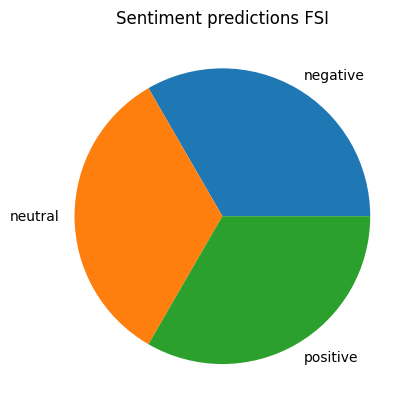

In [39]:
# create pd.dataframe for visualization
df_sentiment = pd.DataFrame(sentiment)
df_sentiment.columns = ["sentiment"]
df_sentiment.loc[ df_sentiment["sentiment"] == "0", "sentiment"] = "positive"
df_sentiment.loc[ df_sentiment["sentiment"] == "1", "sentiment"] = "negative"
df_sentiment.loc[ df_sentiment["sentiment"] == "2", "sentiment"] = "neutral"

# print plot
df_sentiment["sentiment"].value_counts().plot(kind="pie", title="Sentiment predictions FSI", ylabel="")